# Sentiment Analysis on Movie Reviews
## Classify the sentiment of sentences from the Rotten Tomatoes dataset

### Load Data

In [1]:
# load data libraries
import numpy as np # linear algebra library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile # to read zip files
from sklearn.model_selection import train_test_split


# data understanding libraries
import matplotlib.pyplot as plt # ploting library
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter


# data preparation
import re
from nltk.stem import PorterStemmer


# ADS Creation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler

# Modeling
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB

# Evaluation and Model Selection
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

In [2]:
#unzip the files
archive_train = zipfile.ZipFile('train.tsv.zip')

#read training json file 
train = pd.read_csv('train.tsv.zip',sep='\t')

#output the frist 5 rows
train.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


### Splitting Data

In [3]:
train_data, test_data = train_test_split(train, test_size=0.4, random_state=1)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=1)

train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [4]:
print("Train set size is ",len(train_data))
print("Val set size is ",len(val_data))
print("Test set size is ",len(test_data))

Train set size is  93636
Val set size is  31212
Test set size is  31212


### Data Exploration

##### Structure of Data

In [5]:
train.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [7]:
train.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

##### Frequency of each sentiment

In [8]:
# words num
count = " ".join([row["Phrase"] for ind , row in train_data.iterrows()]).split()
len(set(count))

18096

In [9]:
# let's save list of sentiment we have
labels = train_data['Sentiment'].unique()

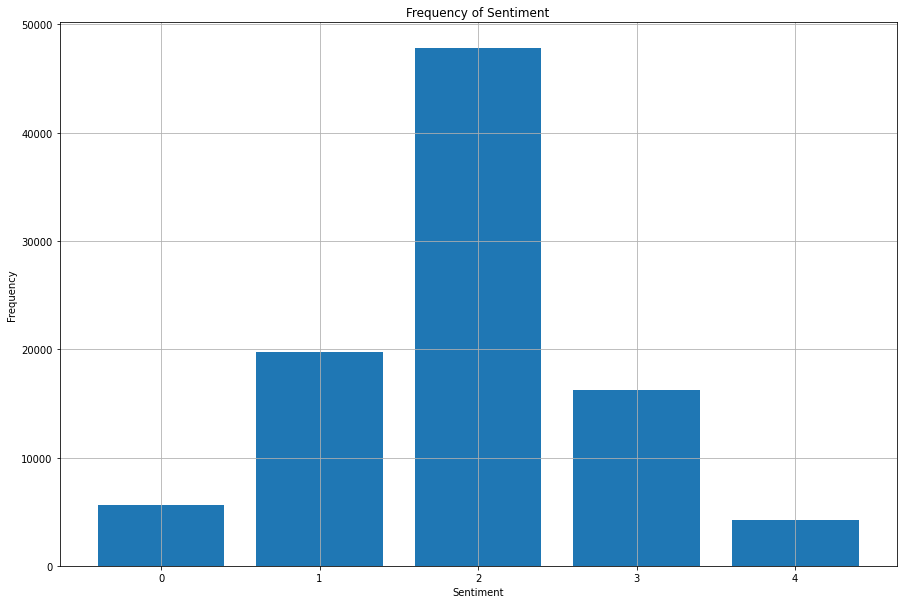

In [10]:
# plot the graph
fig, ax = plt.subplots(figsize=(15,10)) # create the plot and specify the figure size
plt.xlabel('Sentiment') # specify the x labels
plt.ylabel('Frequency') # specify the y labels
plt.title('Frequency of Sentiment') # specify the plot title
plt.bar(labels,train_data['Sentiment'].value_counts()) # create a bar plot
plt.grid() # show the grid
plt.show() # show the final plot

Sentiment class with highest frequency is 2

### Number of words per phrase

In [11]:
# add column with num of words per phrase

train_data['Words_Num'] = train_data["Phrase"].apply(len)

# save list of the unique numbers we have
numbers = train_data["Phrase"].apply(len).unique()


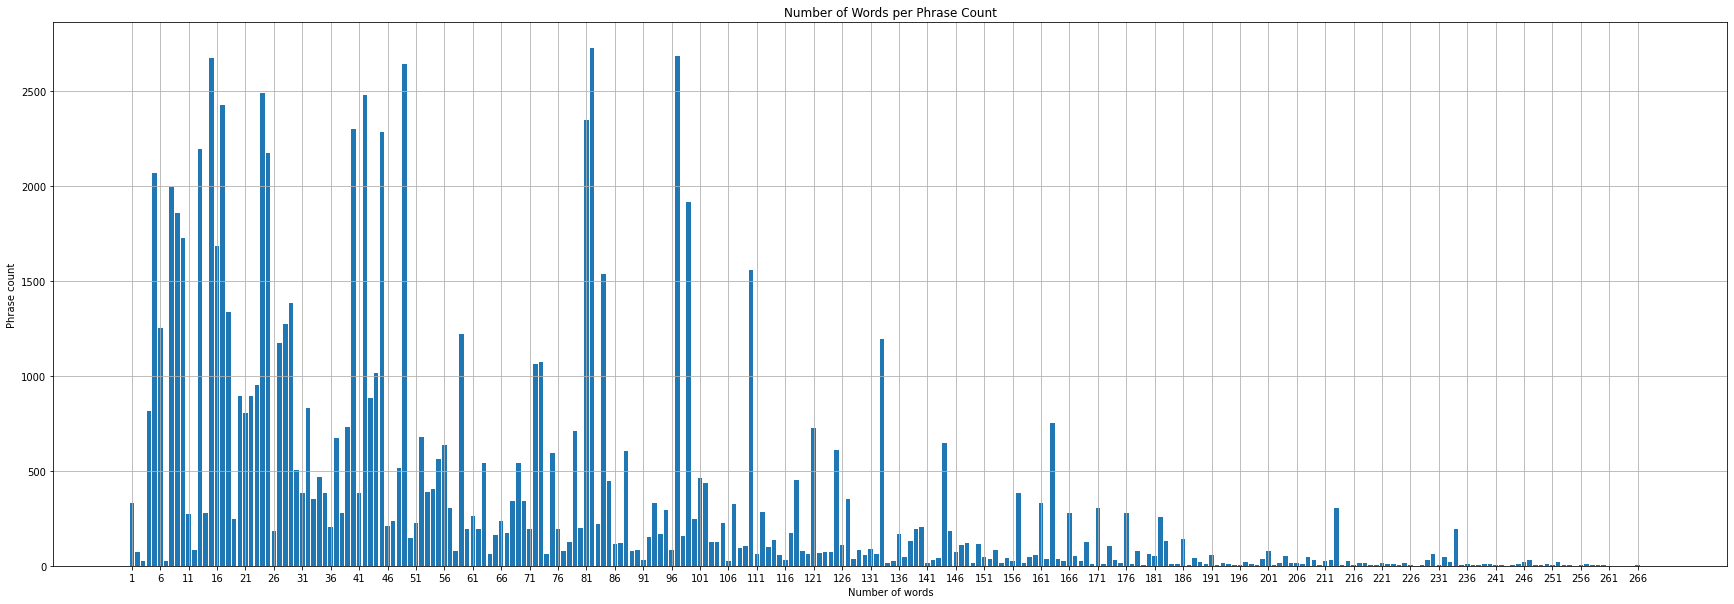

In [12]:
fig, ax = plt.subplots(figsize=(30,10))
plt.bar(numbers,train_data["Words_Num"].value_counts().sort_index())
plt.xlabel('Number of words')
plt.ylabel('Phrase count')
plt.title('Number of Words per Phrase Count')
plt.xticks(np.arange(min(numbers), max(numbers)+1, 5.0)) # change x labels from the defult to the given range
plt.grid()
plt.show()


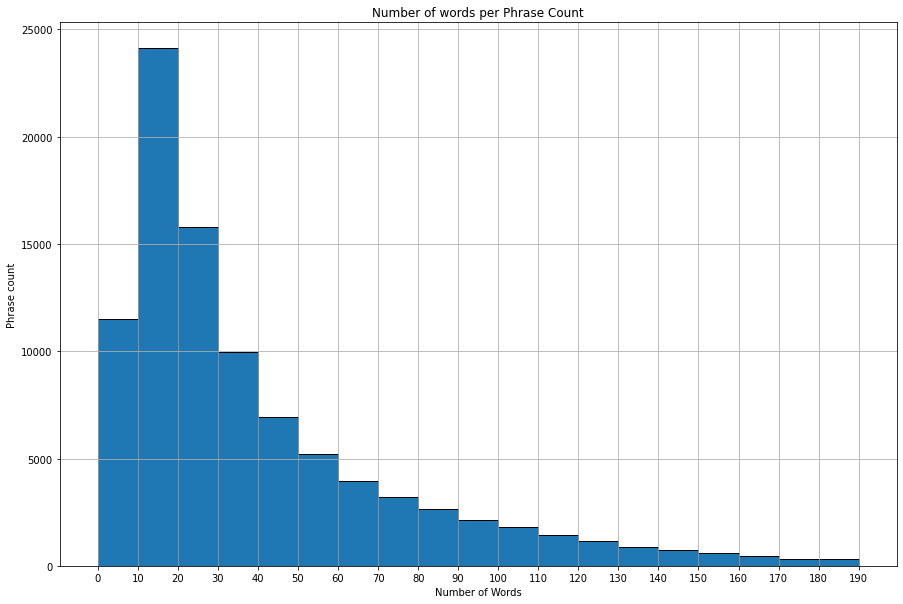

In [13]:
bins = range(0,200,10)

fig, ax = plt.subplots(figsize=(15,10))
plt.hist(train_data['Words_Num'], bins=bins, edgecolor="k") # output a histogram plot
plt.xlabel('Number of Words')
plt.ylabel('Phrase count')
plt.title('Number of words per Phrase Count')
plt.xticks(bins) # change x labels from the defult to the given range
plt.grid()
plt.show()

- Outliers

In [14]:
print("There are " ,len(train_data[train_data["Words_Num"]<2]), " Phrase with words less than 2.")
print("There are " ,len(train_data[train_data["Words_Num"]>170]), " Phrase with words more than 170.")

There are  25  Phrase with words less than 2.
There are  1189  Phrase with words more than 170.


In [15]:
train_data[train_data["Words_Num"]<2][['Phrase']]

,Phrase
132,H
1258,Q
2555,9
10520,=
18106,:
23599,!
24276,7
27121,?
33921,w
35316,+


- Word Cloud

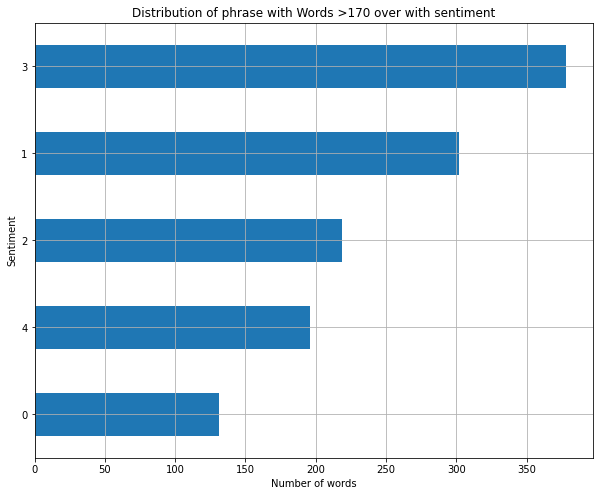

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
train_data[train_data["Words_Num"]>=170].groupby(['Sentiment']).size().sort_values().plot(kind='barh', ax=ax)
plt.title('Distribution of phrase with Words >170 over with sentiment')
plt.ylabel('Sentiment')
plt.xlabel('Number of words')
plt.grid()
plt.show()

- Frequency of words

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'the'),
  Text(1, 0, ','),
  Text(2, 0, 'a'),
  Text(3, 0, 'of'),
  Text(4, 0, 'and'),
  Text(5, 0, 'to'),
  Text(6, 0, '.'),
  Text(7, 0, "'s"),
  Text(8, 0, 'in'),
  Text(9, 0, 'is'),
  Text(10, 0, 'that'),
  Text(11, 0, 'it'),
  Text(12, 0, 'as'),
  Text(13, 0, 'with'),
  Text(14, 0, 'for')])

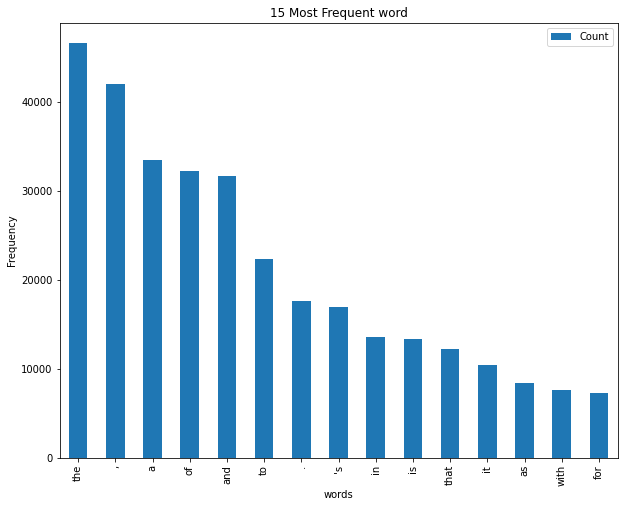

In [17]:
# spliting data
final = " ".join([row["Phrase"] for ind , row in train.iterrows()]).split()



fig, ax = plt.subplots(figsize=(10,8))
lst = Counter(final).most_common(15)
df = pd.DataFrame(lst, columns = ['final', 'Count'])
df.plot.bar(x='final',y='Count', ax=ax)
plt.title('15 Most Frequent word')
plt.ylabel('Frequency')
plt.xlabel('words')
plt.xticks(rotation=90)

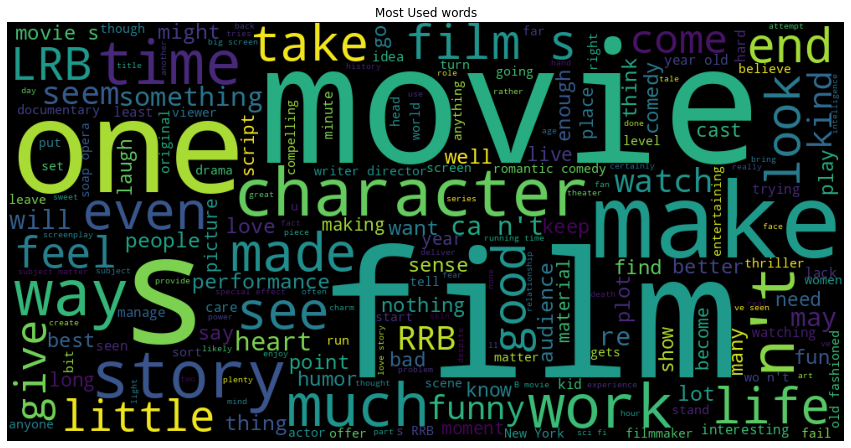

In [18]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(final))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.title("Most Used words")
plt.axis("off")
plt.show()

In [19]:
train_data['SplitPhrase'] =train_data['Phrase'].str.split()
train_data['Phrase'] 

0                                                  Pauline
1                                             trying to go
2                                           a week to live
3                         Essentially a collection of bits
4        The director , with his fake backdrops and sta...
                               ...                        
93631                              concerned with morality
93632                                into the editing room
93633                                       pack raw dough
93634                                   well-wrought story
93635           as the main character suggests , ` what if
Name: Phrase, Length: 93636, dtype: object

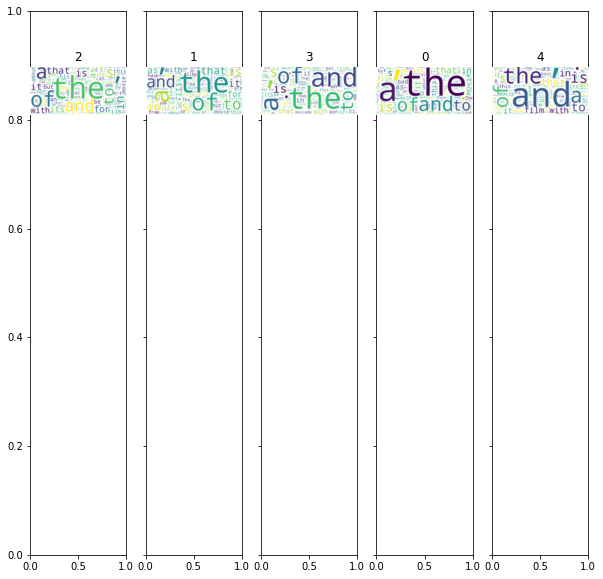

In [20]:

counters = {}
for Sentiment in train_data['Sentiment'].unique():
    counters[Sentiment] = Counter()
    indices = (train_data['Sentiment'] == Sentiment)
    for SplitPhrase in train_data[indices]['SplitPhrase']:
        counters[Sentiment].update(SplitPhrase)

        
fig, axes = plt.subplots(1, 5, figsize=(10,10),sharex='col', sharey='row')
for Sentiment, ax_index in zip(counters, range(1,21)): 
    wordcloud = WordCloud(background_color="white")
    wordcloud.generate_from_frequencies(frequencies=counters[Sentiment])
    fig.add_subplot(3, 5, ax_index)    
    plt.title(Sentiment)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

### Data preparation

In [21]:
train_data['SplitPhrase'].sample(200)

810                                      ['s, not, merely]
46751    [to, the, titular, character, 's, paintings, a...
5188     [For, the, future, ,, one, hopes, Mr., Plympto...
91572            [how, the, heart, accomodates, practical]
1327     [is, ..., very, funny, as, you, peek, at, it, ...
                               ...                        
47696                               [of, suburban, Jersey]
74333                                          [asparagus]
19557                                            [destiny]
67101                                 [plainly, dull, and]
13325    [who, vaguely, resemble, their, celebrity, par...
Name: SplitPhrase, Length: 200, dtype: object

In [22]:
Splited = pd.Series((' '.join([','.join(row["SplitPhrase"]) for ind,row in train_data.iterrows()])).split(','))

In [23]:
pd.Series([s for s in final if "-" in s]).unique()

array(['self-glorification', 'comedy-drama', 'martial-arts', ...,
       'small-budget', 'gang-infested', 'East-vs'], dtype=object)

In [24]:
pd.Series([a for a in final if "'" in a]).unique()

array(["'s", "n't", "'d", "''", "'", "'re", "'m", "O'Fallon", "'60s",
       "'ve", "'n", "'ll", "'n'", "'50s", "'70s", "ol'", "C'mon", "'em",
       "d'etre", "'80s", "'90s", "'53", "'til", "'30s", "'40s"],
      dtype=object)

- Stop words

In [25]:
stopwords = set(["'s","-","","the","that","an"])
porter = PorterStemmer()
# lancaster=LancasterStemmer()

def ret_words(final):
    word_text = ' '.join(final)
    word_text  = final.lower()
    word_text  = final.replace('-', '')
    word_text  = final.replace(',', ' ')
    words = []
    for word in word_text .split():
        if len(word) <= 1: continue
        if re.findall('[0-9]', word): continue
        if '’' in word: continue
        if '-' in word: continue
        if word in stopwords: continue
        if re.findall('[^a-zA-Z]',re.sub(r'[^\w\s]','',word)): continue
        if len(word) > 0: words.append(porter.stem(re.sub(r'[^\w\s]','',word)))
    return ' '.join(words)

def preprocess(df,flag):

    
    # Convert list of ingredients to string
    df['final'] = df["Phrase"].apply(ret_words)
    
    return df

In [26]:
train_preprocessed = preprocess(train_data,0)
val_preprocessed = preprocess(val_data,1)
test_preprocessed = preprocess(test_data,1)

In [27]:
train_preprocessed.head(30)

,PhraseId,SentenceId,Phrase,Sentiment,Words_Num,SplitPhrase,final
0,18674,819,Pauline,2,7,[Pauline],paulin
1,15525,665,trying to go,2,12,"[trying, to, go]",tri to go
2,119919,6413,a week to live,2,14,"[a, week, to, live]",week to live
3,17938,781,Essentially a collection of bits,2,32,"[Essentially, a, collection, of, bits]",essenti collect of bit
4,98852,5185,"The director , with his fake backdrops and sta...",1,59,"[The, director, ,, with, his, fake, backdrops,...",the director with hi fake backdrop and state pace
5,33703,1582,'ll regret,2,10,"['ll, regret]",ll regret
6,152547,8324,have tremendous chemistry,3,25,"[have, tremendous, chemistry]",have tremend chemistri
7,112239,5960,its sequel,2,10,"[its, sequel]",it sequel
8,58522,2948,a cushion of predictable narrative rhythms,2,42,"[a, cushion, of, predictable, narrative, rhythms]",cushion of predict narr rhythm
9,117390,6263,how very bad,0,12,"[how, very, bad]",how veri bad


In [28]:
len(set(pd.Series(' '.join([row["final"] for ind,row in train_preprocessed.iterrows()]).split(' '))))

10329

In [29]:
id_train, X_train, y_train = train_preprocessed['PhraseId'], train_preprocessed['final'], train_preprocessed['Sentiment']
id_test, X_test, y_test = test_preprocessed['PhraseId'], test_preprocessed['final'], test_preprocessed['Sentiment']

In [30]:
# BoW
BoW = CountVectorizer()

BoW.fit(X_train)
Count_data = BoW.transform(X_train)

BoW_X_train = pd.DataFrame(Count_data.toarray(),columns=BoW.get_feature_names())

BoW_X_train

,aaa,aaliyah,aan,abagnal,abandon,abbass,abbott,abbrevi,abc,abderrahman,...,zish,ziyi,zoe,zombi,zone,zooland,zoom,zucker,zwick,zzzzzzzzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93631,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93632,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
X_train.head()

0                                               paulin
1                                            tri to go
2                                         week to live
3                               essenti collect of bit
4    the director with hi fake backdrop and state pace
Name: final, dtype: object

In [32]:
BoW.fit(X_train.head())
Count_data = BoW.transform(X_train.head())
BoW_X_train = pd.DataFrame(Count_data.toarray(),columns=BoW.get_feature_names())
BoW_X_train

,and,backdrop,bit,collect,director,essenti,fake,go,hi,live,of,pace,paulin,state,the,to,tri,week,with
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
3,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,1,1,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,1


In [33]:
#TFIDF
TFIDF = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.25, norm='l2', encoding='latin-1',\
                ngram_range=(1, 2), stop_words='english')

TFIDF.fit(X_train)
Count_data = TFIDF.transform(X_train)
TFIDF_X_train = pd.DataFrame(Count_data.toarray(),columns=TFIDF.get_feature_names())


TFIDF_X_train

,aaliyah,abagnal,abagnal antic,abandon,abandon polit,abandon script,abandon theater,abbass,abbott,abc,...,zombi shoot,zone,zone arm,zone episod,zone left,zone sympath,zone voic,zucker,zucker brothersabraham,zwick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
TFIDF = TfidfVectorizer()
TFIDF.fit(X_train.head(5))
Count_data = TFIDF.transform(X_train.head(5))
TFIDF_X_train = pd.DataFrame(Count_data.toarray(),columns=TFIDF.get_feature_names())


TFIDF_X_train

,and,backdrop,bit,collect,director,essenti,fake,go,hi,live,of,pace,paulin,state,the,to,tri,week,with
0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.614189,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.495524,0.614189,0.000000,0.000000
2,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.614189,0.0,0.000000,0.0,0.000000,0.000000,0.495524,0.000000,0.614189,0.000000
3,0.000000,0.000000,0.5,0.5,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.333333,0.333333,0.0,0.0,0.333333,0.0,0.333333,0.000000,0.333333,0.000000,0.0,0.333333,0.0,0.333333,0.333333,0.000000,0.000000,0.000000,0.333333


### Modelling

In [35]:
id_train, X_train, y_train = train_preprocessed['PhraseId'], train_preprocessed['final'], train_preprocessed['Sentiment']
id_val, X_val, y_val = val_preprocessed['PhraseId'], val_preprocessed['final'], val_preprocessed['Sentiment']
id_test, X_test, y_test = test_preprocessed['PhraseId'], test_preprocessed['final'], test_preprocessed['Sentiment']

- BOW

In [36]:
LR_clf_counts = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(random_state=0, max_iter=2000))
])
LR_clf_counts.fit(X_train, y_train)
LR_cnt_pred_tr = LR_clf_counts.predict(X_train)

print(accuracy_score(y_train, LR_cnt_pred_tr))
print(precision_score(y_train, LR_cnt_pred_tr, average='weighted'))

0.7041095305224486
0.7001941158715469


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


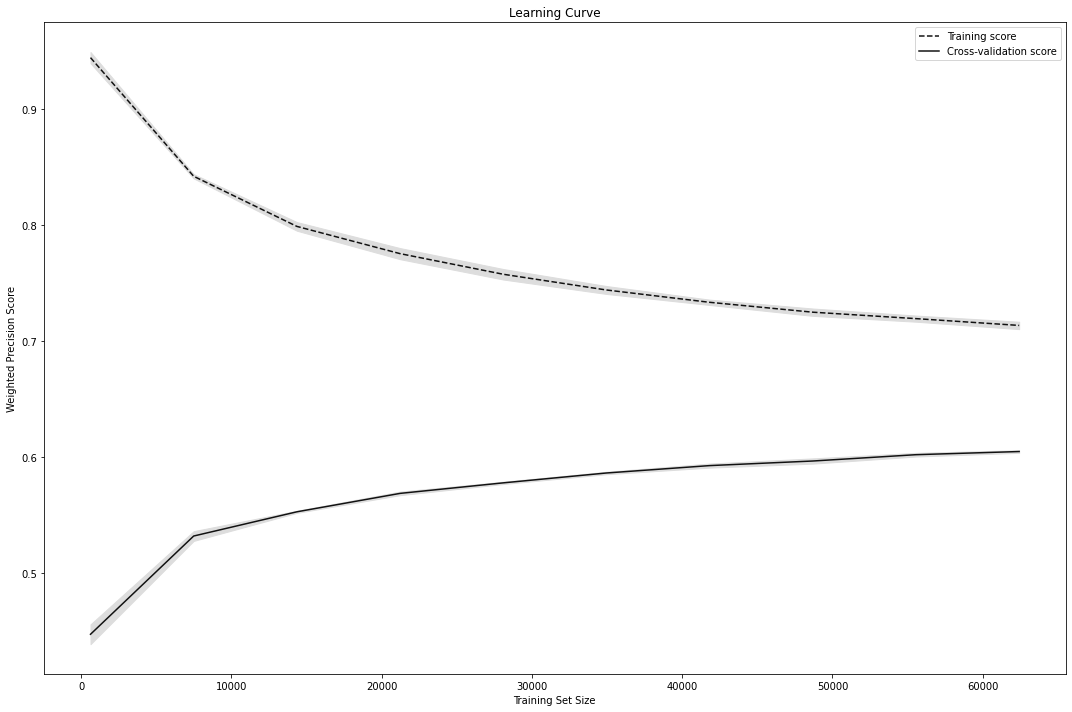

In [37]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LR_clf_counts, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

- SVM

In [38]:
SVM_clf_counts = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LinearSVC(max_iter=3000))
])
SVM_clf_counts.fit(X_train, y_train)
SVM_cnt_pred_tr = SVM_clf_counts.predict(X_train)

print(accuracy_score(y_train, SVM_cnt_pred_tr))
print(precision_score(y_train, SVM_cnt_pred_tr, average='weighted'))

0.7083920714255201
0.7043311742883853


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


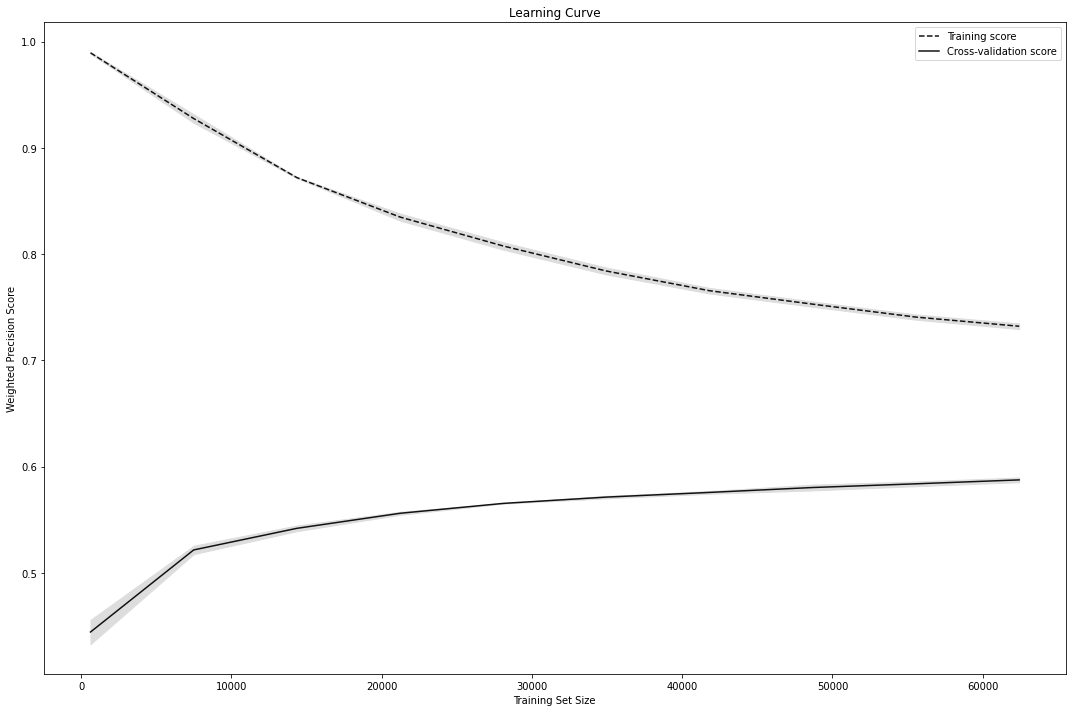

In [39]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVM_clf_counts, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Naive Bayes

In [40]:
NB_clf_counts = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])
NB_clf_counts.fit(X_train, y_train)
NB_cnt_pred_tr = NB_clf_counts.predict(X_train)

print(accuracy_score(y_train, NB_cnt_pred_tr))
print(precision_score(y_train, NB_cnt_pred_tr, average='weighted'))

0.6636870434448289
0.6526578147593806


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


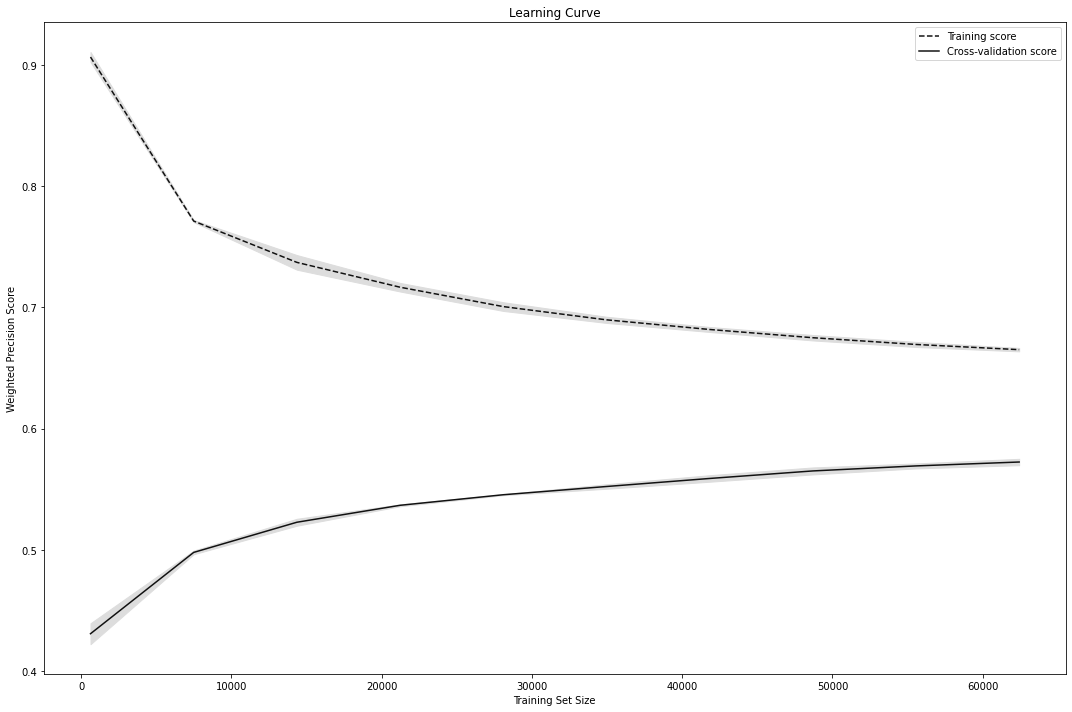

In [41]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(NB_clf_counts, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

- lR and tfidf

In [42]:
LR_clf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.25, norm='l2', encoding='latin-1',ngram_range=(1, 2), stop_words='english')),
    ('clf', LogisticRegression(random_state=0, max_iter=2000))
])
LR_clf_tfidf.fit(X_train, y_train)
LR_tfidf_pred_tr = LR_clf_tfidf.predict(X_train)

print(accuracy_score(y_train, LR_tfidf_pred_tr))
print(precision_score(y_train, LR_tfidf_pred_tr, average='weighted'))

0.7014609765474817
0.7017416721675043


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Pr

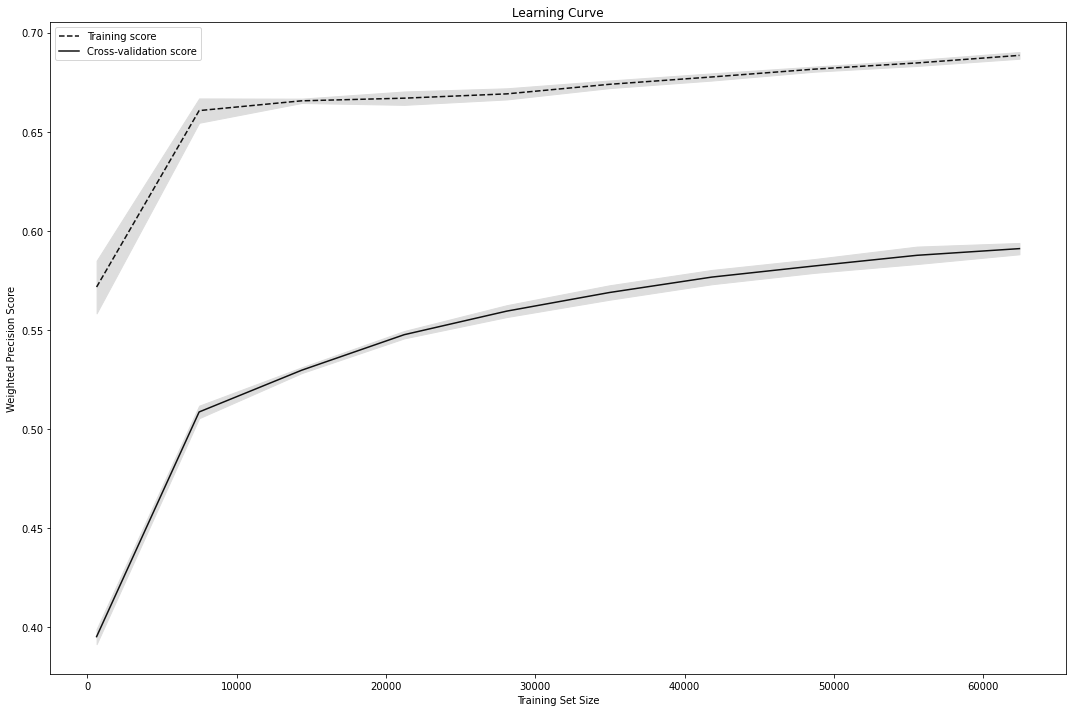

In [43]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(LR_clf_tfidf, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [44]:
SVM_clf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.25, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),
    ('clf', LinearSVC( max_iter=2000))
])
SVM_clf_tfidf.fit(X_train, y_train)
SVM_tfidf_pred_tr = SVM_clf_tfidf.predict(X_train)

print(accuracy_score(y_train, SVM_tfidf_pred_tr))
print(precision_score(y_train, SVM_tfidf_pred_tr, average='weighted'))

0.7584689649280192
0.7546649786097949


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


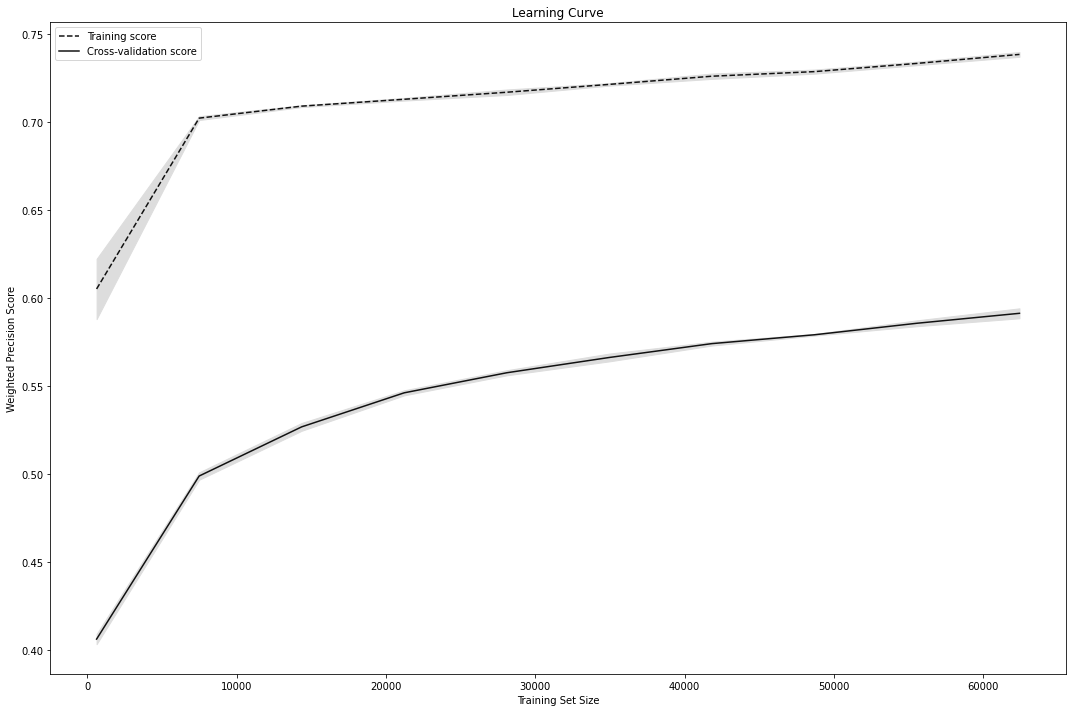

In [45]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(SVM_clf_tfidf, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [46]:
NB_clf_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.25, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),
    ('clf', MultinomialNB())
])
NB_clf_tfidf.fit(X_train, y_train)
NB_tfidf_pred_tr = NB_clf_tfidf.predict(X_train)

print(accuracy_score(y_train, NB_tfidf_pred_tr))
print(precision_score(y_train, NB_tfidf_pred_tr, average='weighted'))

0.657279251569909
0.6759767908453588


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Pr

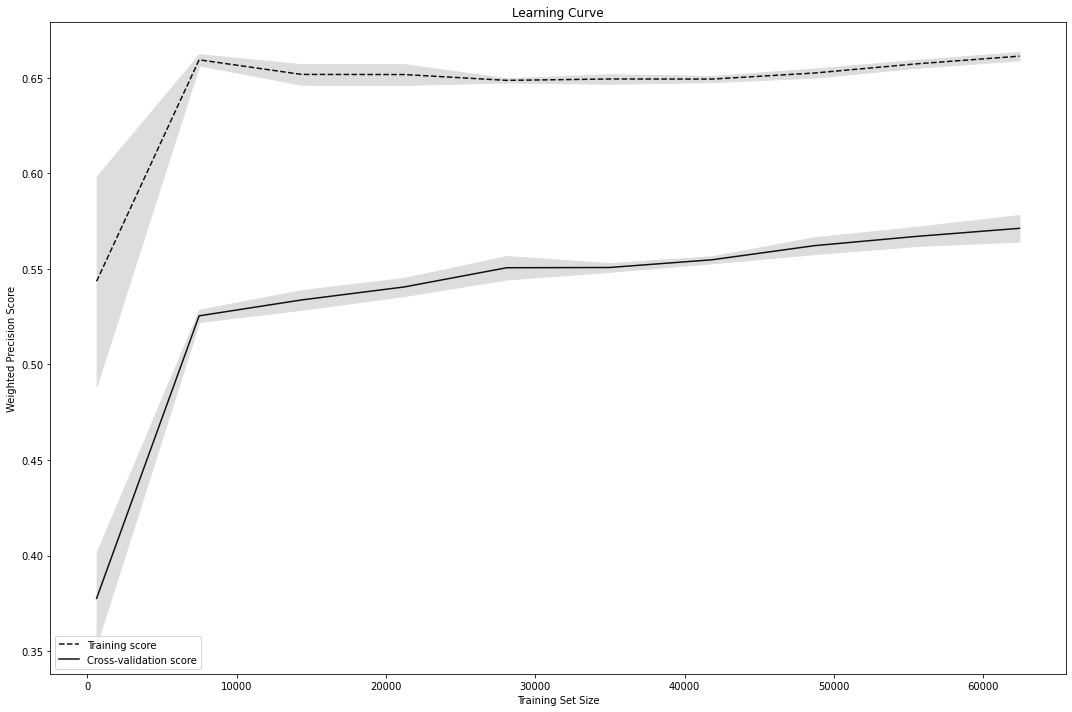

In [47]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(NB_clf_tfidf, 
                                                        X_train, 
                                                        y_train,
                                                        # Number of folds in cross-validation
                                                        cv=3,
                                                        # Evaluation metric
                                                        scoring='precision_weighted',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 10))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
fig, ax = plt.subplots(figsize=(15,10))
# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Weighted Precision Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Hyper parameter tuning

In [48]:
vect=  CountVectorizer()
X_train_cnt = vect.fit_transform(X_train)


In [49]:
def svc_param_selection(X, y, nfolds, kernal):
    Cs = [ 0.1, 1, 10]
    gammas = [0.01, 0.1, 1]
    degrees = [0, 1, 2, 3]
    rbf_param_grid = {'C': Cs, 'gamma' : gammas}
    linear_param_grid = {'C': Cs}
    poly_param_grid = {'C': Cs, 'gamma' : gammas, 'degree':degrees}
    if kernal == 'rbf':
        grid_search = GridSearchCV(SVC(kernel=kernal), rbf_param_grid, cv=nfolds)
    elif kernal == 'linear':
        grid_search = GridSearchCV(SVC(kernel=kernal), linear_param_grid, cv=nfolds)
    else:
        grid_search = GridSearchCV(SVC(kernel=kernal), poly_param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


### Model

In [50]:
vect=  CountVectorizer()
X_train_cnt = vect.fit_transform(X_train)

In [51]:
def svc_param_selection(X, y, nfolds, kernal):
    Cs = [ 0.1, 1, 10]
    gammas = [0.01, 0.1, 1]
    degrees = [0, 1, 2, 3]
    rbf_param_grid = {'C': Cs, 'gamma' : gammas}
    linear_param_grid = {'C': Cs}
    poly_param_grid = {'C': Cs, 'gamma' : gammas, 'degree':degrees}
    if kernal == 'rbf':
        grid_search = GridSearchCV(SVC(kernel=kernal), rbf_param_grid, cv=nfolds)
    elif kernal == 'linear':
        grid_search = GridSearchCV(SVC(kernel=kernal), linear_param_grid, cv=nfolds)
    else:
        grid_search = GridSearchCV(SVC(kernel=kernal), poly_param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [52]:
SVM_clf_counts_lin = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(C=0.1, kernel='linear'))
])
SVM_clf_counts_lin.fit(X_train, y_train)
SVM_cnt_pred_tr_lin = SVM_clf_counts_lin.predict(X_train)
SVM_cnt_pred_val_lin = SVM_clf_counts_lin.predict(X_val)
SVM_tst = SVM_clf_counts_lin.predict(X_test)



print("precision on training: ",precision_score(y_train, SVM_cnt_pred_tr_lin, average='micro'))
print("precision on validation: ",precision_score(y_val, SVM_cnt_pred_val_lin, average='micro'))
print("precision on testing: ",precision_score(y_test, SVM_tst, average='micro'))


precision on training:  0.6412704515357341
precision on validation:  0.6105984877611175
precision on testing:  0.613514033064206


In [53]:
archive_train = zipfile.ZipFile('train.tsv.zip')
archive_test = zipfile.ZipFile('test.tsv.zip')

In [54]:
final_train = pd.read_csv("train.tsv.zip", sep='\t')
final_test = pd.read_csv("test.tsv.zip", sep='\t')

In [55]:
ftrain_preprocessed = preprocess (final_train,0)
ftest_preprocessed = preprocess (final_test,1)

In [56]:
id_train, X_train, y_train = ftrain_preprocessed['PhraseId'], ftrain_preprocessed['final'], ftrain_preprocessed['Sentiment']
id_test, X_test= ftest_preprocessed['PhraseId'], ftest_preprocessed['final']

In [ ]:
SVM_clf= Pipeline([
    ('vect', CountVectorizer()),
    ('clf', SVC(C=0.1, kernel='linear'))
])
SVM_clf.fit(X_train , y_train)
pred_tst = SVM_clf_counts_lin.predict(X_test)

In [ ]:
output=pd.DataFrame({'PhraseId' : id_test , 'Sentiment' : pred_tst })
output.to_csv('Sentiment_preds_LR.csv' , index=False)